<img src="https://heig-vd.ch/docs/default-source/doc-global-newsletter/2020-slim.svg" alt="Logo HEIG-VD" style="width: 80px;" align="right"/>

# Cours APN - Labo 6 : Autoencodeurs et détection de fraudes

## Résumé
Le but de ce laboratoire est d'entraîner des autoencodeurs sur des données de transactions bancaires, en mode non supervisé.  La fonction de coût sera la capacité de l'autoencodeur à reproduire en sortie les données d'entrée.  Trois réseaux de neurones autoencodeurs seront testés.

Ensuite, on considérera que les données mal reconstruites sont atypiques, et on testera l'hypothèse qu'il s'agit de transactions frauduleuses.  On utilisera donc cette information pour évaluer la capacité de l'autoencodeur à détecter les fraudes.

In [1]:
import numpy as np
import pandas as pd
import keras # pour l'installation, "pip install tensorflow" suffira
import tensorflow as tf

2023-12-08 11:52:47.845646: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Données : source

Vous utiliserez un jeu de données fourni par le [Groupe ML de l'Université Libre de Bruxelles](http://mlg.ulb.ac.be/), disponible sur Kaggle : https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud.  Pour simplifier, une version vous est fournie sur Switchdrive dans un fichier [creditcard.zip](https://drive.switch.ch/index.php/s/lBqMRsADWrU2S4R).  Voici la description des données par les auteurs :

> The dataset contains transactions made by credit cards over two days in September 2013 by European cardholders.  It contains only numerical input variables which are the result of a PCA transformation (due to confidentiality issues).  Features V1, ..., V28 are the principal components.  Two features were not transformed: 'Time' (seconds since the 1st transaction) and 'Amount'.  

> The feature 'Class' takes value 1 in case of a fraudulent transaction and 0 otherwise.  There are 492 frauds out of 284,807 transactions (0.17%).  As the dataset is highly unbalanced, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC), not with confusion matrices.

## 1. Charger et préparer les données
a. Chargez les données de `creditcard.csv` directement dans une *dataframe* Pandas appelée `data`.

In [3]:
data = pd.read_csv("creditcard.csv")
data.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


b. Affichez quelques informations sur ces données et leurs caractéristiques.

In [4]:
print(f"Longueur: {len(data)}")
data.describe().loc[["mean", "std", "min", "50%", "max"]]

Longueur: 284807


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


c. Construisez une nouvelle *dataframe* appelée `data_labels` contenant seulement l'attribut qui indique si une transaction est frauduleuse ou non (attribut `Class`).  Supprimez les attributs `Time` et `Class` de la *dataframe* initiale `data`.

In [5]:
data_labels = pd.DataFrame(data["Class"])

data = data.drop(["Time", "Class"], axis=1)

d. Normalisez toutes les colonnes de `data` vers des valeurs de moyenne nulle et d'écart-type égal à 1 (distribution centrée réduite). Utilisez pour cela le `StandardScaler` de scikit-learn.

In [6]:
scaled_data = StandardScaler().fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,0.083386,...,0.326118,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964
1,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,-0.153350,...,-0.089611,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475
2,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,0.190700,...,0.680975,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686
3,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,-0.050468,...,-0.269855,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534
4,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,0.691625,...,0.529939,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403
5,-0.217475,0.581675,0.752585,-0.118833,0.305009,-0.022313,0.384936,0.217955,-0.517619,-0.341101,...,0.110215,-0.283522,-0.771427,-0.042273,-0.613273,-0.446584,0.219637,0.628900,0.245636,-0.338556
6,0.627795,0.085389,0.029923,0.849383,0.139020,0.204695,-0.004170,0.067998,0.423218,-0.091155,...,-0.284895,-0.228334,-0.373032,-0.246780,-1.287973,1.439037,-0.533436,0.085492,0.015656,-0.333279
7,-0.328928,0.858692,0.708576,-0.347631,0.687512,0.321345,0.905860,-3.188229,0.560129,1.147430,...,-0.203317,2.645889,-1.399276,0.092085,-1.072754,-0.796633,-0.107075,-2.990154,-3.288083,-0.190107
8,-0.456573,0.173291,-0.074653,-0.191774,1.934149,2.793594,0.299206,0.712592,-0.356851,-0.376940,...,0.068406,-0.099963,-0.369425,-0.327055,1.670269,0.715943,-0.796633,0.029104,0.431420,0.019392
9,-0.172698,0.678005,0.688781,-0.156927,0.361792,-0.185219,0.526706,0.058223,-0.670587,-0.336912,...,0.264243,-0.336156,-0.873298,-0.193438,-0.635767,-0.133773,0.195342,0.610010,0.251681,-0.338516


e. Pourquoi est-il acceptable ici de ne pas diviser `data` en données d'entraînement et de test ?

# 2. Définir les fonctions d'évaluation du modèle
Veuillez définir deux fonctions qui affichent :
   1. la courbe précision-rappel et la précision moyenne (qui est aussi la valeur de retour)
   1. la courbe ROC et l'aire sous la courbe (qui est aussi la valeur de retour)

Puis, veuillez recopier leur code et écrire une fonction qui affiche les deux courbes ensemble.

Ces fonctions, spécifiées ci-dessous, utilisent les classes et fonctions importées de `sklearn.metrics` au début de ce notebook.  Veuillez consulter leur documentation pour savoir comment les utiliser.

Une fonction auxiliaire vous est donnée, qui mesure l'erreur de reconstruction entre les données d'origine et celles reconstruites par un autoencodeur.

In [7]:
def reconstruction_error(X_orig, X_pred):
    '''
    Mesure l'erreur de reconstruction pour l'ensemble des données (compare 2 dataframes).
    Retourne une série avec l'erreur de chaque point de données.
    '''
    loss = np.sum((np.array(X_orig) - np.array(X_pred))**2, axis=1) # carré de l'erreur pour chaque item
    loss = pd.Series(data = loss, index = X_orig.index) # transformer en Series
    loss = (loss - np.min(loss)) / (np.max(loss) - np.min(loss)) # normalisation sur tous les items vers [0, 1]
    return loss

Veuillez écrire une fonction pour afficher la courbe précision-rappel et retourner la précision moyenne.  Veuillez écrire une fonction pour afficher la courbe ROC.  Enfin, veuillez copier le code dans une fonction qui affiche les deux courbes ensemble.  

In [8]:
def display_pr_curve(labels, rec_errors, baseline=[]):
    '''
    Affiche la courbe précision-rappel et retourne la moyenne de la précision.
    labels     = les classes correctes : {0, 1} pour chaque item
    rec_errors = les nombres prédits par l'autoencodeur pour chaque item, dans [0, 1]
    baseline   = les nombres prédits par une autre méthode, en général baseline, dans [0, 1]
    '''
    precision, recall, _ = precision_recall_curve(labels, rec_errors)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()

In [9]:
def display_roc_curve(labels, rec_errors, baseline=[]):
    '''
    Affiche la courbe ROC et retourne l'aire sous la courbe ROC.
    labels     = les classes correctes : {0, 1} pour chaque item
    rec_errors = les nombres prédits par l'autoencodeur pour chaque item, dans [0, 1]
    baseline   = les nombres prédits par une autre méthode, en général baseline, dans [0, 1]
    '''
    fpr, tpr, _ =  roc_curve(labels, rec_errors)

    fig, ax = plt.subplots()
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax)
    if len(baseline) > 0:
        fpr, tpr, _ = roc_curve(labels, rec_errors)
        RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax)
    plt.show()

In [10]:
def display_pr_roc(labels, rec_errors, baseline=[]):
    '''
    Affiche côte à côte la courbe précision-rappel et la courbe ROC. 
    Retourne la moyenne de la précision et l'aire sous la courbe ROC.
    labels     = les classes correctes : {0, 1} pour chaque item
    rec_errors = les nombres prédits par l'autoencodeur pour chaque item, dans [0, 1]
    baseline   = les nombres prédits par une autre méthode, en général baseline, dans [0, 1]
    '''

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(12)

    precision, recall, _ = precision_recall_curve(labels, rec_errors)
    fpr, tpr, _ =  roc_curve(labels, rec_errors)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax1)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax2)
    plt.plot()
    plt.show()


## 3. Tester des modèles *baseline*

On considère deux modèles *baseline* pour des valeurs de reconstruction:
   1. des scores aléatoires dans [0, 1] pour chaque item : `np.random.rand(data.shape[0])`
   1. la norme L2 du vecteur d'attributs de chaque transaction, normalisée par colonne entre 0 et 1, qui peut être obtenue simplement ainsi avec la fonction définie plus haut : `reconstruction_error(data, np.zeros(data.shape[0]))`
   
Veuillez afficher les courbes précision-rappel et ROC pour ces deux *baselines* en même temps, grâce à la fonction précédente.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


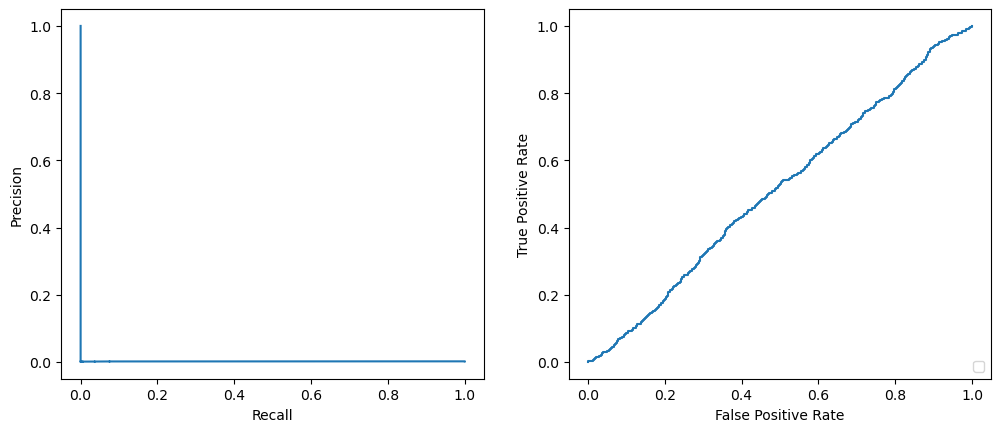

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


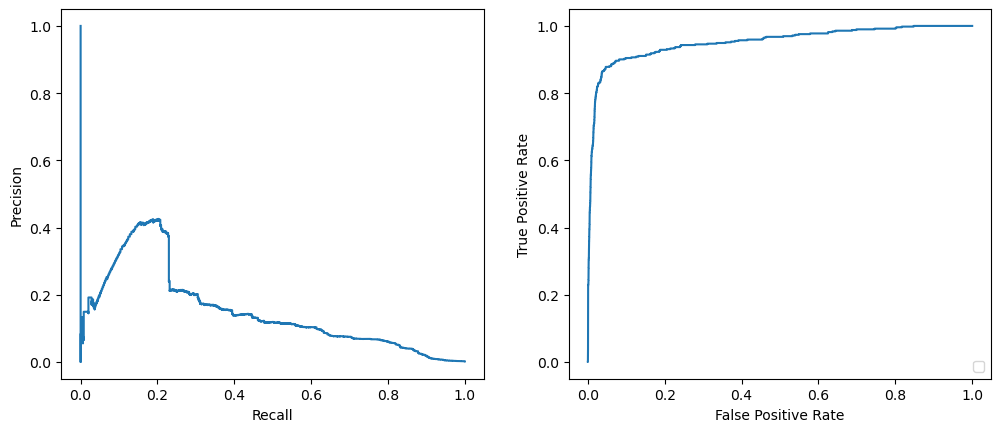

In [11]:
baseline1 = np.random.rand(data.shape[0])
baseline2 = reconstruction_error(data, np.zeros(data.shape))

display_pr_roc(data_labels, baseline1)
display_pr_roc(data_labels, baseline2)

Sachant que les données proviennent d'une transformation PCA des données de transaction originales (auxquelles nous n'avons pas accès), pouvez-vous tenter d'expliquer le score non-nul obtenu par la 2e baseline ?

**Réponse**: En utilisant la norme L2 des vecteurs on procède à une sorte de réduction de la dimensionalité finale vers une seule dimension. La prédiction est donc dérivée de l'information présente dans les données, d'où son score non-nul.

## 4. Définir des fonctions pour entraîner, valider, et évaluer des modèles

Veuillez définir une fonction `train` qui entraîne un *modèle* (que vous créerez plus bas avec Keras) sur un jeu de *données*, avec l'objectif de reconstruire les données (donc les données d'entrée et de sortie pour un entraînement supervisé sont identiques).  Toutes les *x* époques d'entraînement (`epochs_per_iteration`) la fonction `train` affiche les scores de *précision moyenne* et de *aire sous la courbe ROC*, mais pas les graphiques.  La fonction itère cela *y* fois (`nb_iterations`).

Veuillez définir aussi une fonction `evaluate` qui affiche les courbes précision-rappel et ROC pour un modèle, et inclut dans chaque graphique la *baseline* de la norme L2 des données initiales (2e baseline de la section 3).

Vous pouvez utiliser ces [méthodes de Keras](https://keras.io/api/models/model_training_apis) :
   * [model.fit(...)](https://keras.io/api/models/model_training_apis/#fit-method) pour lancer un certain nombre de pas d'entraînement (*backward pass*)
   * [model.predict(...)](https://keras.io/api/models/model_training_apis/#predict-method) pour exécuter le modèle sur des données et obtenir la sortie (*forward pass*)

In [12]:
def train(model, data, epochs_per_iteration = 10, nb_iterations = 10):
    for _ in range(nb_iterations):
        for epoch in range(epochs_per_iteration):
            model.fit(data, data)
            print(epoch)
    

In [13]:
def evaluate(model, data, data_labels):
    pass


## 5. Créer, entraîner et évaluer des autoencodeurs 

### 5.1. Autoencodeur simple à trois couches

Veuillez définir en Keras un autoencodeur à trois couches, avec une couche de codage ayant une dimension plus faible que celle d'entrée (*undercomplete autoencoder*).  Utiliser un modèle de type `Sequential()` avec des couches entièrement connectées de type `Dense()`, en vous guidant sur les [exemples de Keras](https://keras.io/api/models/sequential/).  Choisissez une fonction de coût (*loss*) et un optimiseur appropriés.  N'oubliez pas de [compiler le modèle](https://keras.io/api/models/model_training_apis/#compile-method) à la fin.

In [14]:
def tf_reconstruction_error(X_orig, X_pred):
    return reconstruction_error(X_orig.numpy(), X_pred.numpy())

In [18]:
model = keras.Sequential(name="autoencodeur")
model.add(keras.Input(shape=(data.shape[1],), name="input"))
model.add(keras.layers.Dense(3, activation="sigmoid", name="hidden"))
model.add(keras.layers.Dense(data.shape[1], activation="sigmoid", name="output"))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.05), loss="binary_crossentropy")
model.summary()

Model: "autoencodeur"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 3)                 90        
                                                                 
 output (Dense)              (None, 29)                116       
                                                                 
Total params: 206
Trainable params: 206
Non-trainable params: 0
_________________________________________________________________


In [16]:
# model.save('modele_1.h5')  # enregistrer le modèle
# del model  # supprimer le modèle de la mémoire
# model = keras.models.load_model('modele_1.h5') # charger le modèle

Veuillez entraîner le modèle avec la fonction `train` que vous avez définie plus haut.  Selon vos résultats intermédiaires, écrivez ici la commande qui semble suffisante pour atteindre le maximum de performance, et affichez ses résultats.  Notez que le modèle est sauvegardé, donc plusieurs appels à `train` permettent de continuer l'entraînement.  Dans votre rapport final, indiquez explicitement la durée totale en nombre d'époques.

In [19]:
train(model, data, 20, 10)

8901/8901 [==============================] - 29s 3ms/step - loss: -22.8449
0
8901/8901 [==============================] - 30s 3ms/step - loss: -69.2242
1
4845/8901 [===============>..............] - ETA: 12s - loss: -105.4655


KeyboardInterrupt



Veuillez afficher les deux courbes (y compris les *baselines*), et les scores du modèle avec la fonction `evaluate`.

In [ ]:
evaluate(model, data, data_labels)

**Veuillez discuter vos résultats.**  Comment jugez-vous la capacité du modèle à détecter des transactions frauduleuses, compte tenu du fait qu'il n'a jamais été entraîné de manière supervisée ?  Comment se compare-t-il avec la baseline ?  Quelle est sa précision maximale, et pour quel rappel est-elle atteinte ?  (Approximativement, d'après le graphique.)  Comment interprétez-vous ces valeurs ?

### 5.2. Autoencodeur à cinq couches

Veuillez définir maintenant un autoencodeur à cinq couches, sur le même principe que le précédent, toujours *undercomplete*.  Effectuez son entraînement et son évaluation finale, comme pour le modèle à 3 couches.

In [ ]:
train(model, data, 10, 10)

In [ ]:
model.save('modele_2.h5')  # enregistrer le modèle
# del model  # supprimer le modèle de la mémoire
# model = keras.models.load_model('modele_1.h5') # charger le modèle

In [ ]:
evaluate(model, data, data_labels)

Veuillez discuter vos résultats et les comparer avec les précédents.

### 5.3. Autoencodeur à trois couches, *overcomplete*, avec *sparsity*
Veuillez enfin définir un autoencodeur à trois couches, mais avec une couche cachée ayant une dimension supérieure à celle des couches d'entrée et de sortie.  Afin d'éviter la pure copie entrée/sortie, ajoutez une contrainte de régularisation sur la couche cachée, qui limite la somme des valeurs absolues des activations dans cette couche (voir la [documentation](https://keras.io/api/layers/regularizers/) de Keras).

In [ ]:
train(model, data, 10, 10)

In [ ]:
# model.save('modele_3.h5')  # enregistrer le modèle
# del model  # supprimer le modèle de la mémoire
# model = keras.models.load_model('modele_1.h5') # charger le modèle

In [ ]:
evaluate(model, data, data_labels)

Veuillez discuter vos résultats et les comparer avec les précédents.

### Fin du laboratoire 6
Veuillez nettoyer le *notebook* et y inclure l'affichage des résultats de vos systèmes définitifs.  Ne pas effacer les logs d'entraînement et les graphiques.  Veuillez ensuite soumettre le *notebook* sur Cyberlearn.